# Attempting to Model Elevator Situation with SimPy
## The Problem
My apartment building has three elevators, but one is reserved for freight. So, it really has two elevators which are called with one button. 

One of the elevators broke down, so the building opened the freight elevator up to the residents. The freight elevator has its own button on each floor.

I noticed one day as I was descending that my elevator kept stopping and no one would get in. The people in my building had started pressing both buttons and then getting in the elevator that arrived first.

That got me thinking about math. Here are my research questions:
1. Are we all worse off if everyone does this behavior?
2. Is there a threshold for how many people have to do this to make it worse?
3. Can we solve this problem through simulation and probability (numerical and analytical)?

I don't know much about queuing theory or probability, so this is going to be challenging for me. I will start with the numerical approach

# Dependencies

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Simplifying Assumption
- Elevator going down picks up people that want to be picked up (regardless of when they push button)
- If someone gets on at a non lobby floor, they're going to the lobby
- Elevator drops off on its way up and on the way down at the lobby.

# Defining an Elevator Class
We're going to have multiple elevators, which all do the same thing. Good time to make a class.

In [2]:
class Elevator(object):
    def __init__(self, name, debug=False, wait_time=5, n_floors=23):
        self.name = name
        self.wait_time = wait_time
        self.n_floors = n_floors
        self.loc = 0 # current floor
        self.moving_up = True # default is true because elevator starts on ground
        self.to_pick_up, self.to_drop_off = [], []
        self.stopped = 0 # works as a timer, if its zero, not stopped
        self.idle = True # Elevator isn't doing anything
        self.throughput = 0# number of customers served
        self.average_times = []
        self.time = 0
        self.debug = debug
        
    def __str__(self):
        ans = self.name + ': '
        if self.idle:
            ans += 'idle'
        elif self.stopped > 0:
            ans += 'stopped'
        elif self.should_stop():
            ans += 'stopping to pick up or drop off'
        elif len(self.to_drop_off) == 0 and len(self.to_pick_up) == 0:
            ans += 'switching to idle'
        else:
            ans += f'moving, moving_up: {self.moving_up}'
        ans += '\npassenger dests: ' + ', '.join([str(cust.dest) for cust in self.to_drop_off]) 
        return ans
    
    def move(self, time):
        self.time = time
        if self.idle:
            return
        elif self.stopped > 0:
            # if stopped, stay stopped
            # can pick up more customers
            self.stopped -= 1
            self.pick_up()
            self.drop_off()
        elif self.should_stop():
            self.pick_up_and_drop_off()
        elif len(self.to_drop_off) == 0 and len(self.to_pick_up) == 0:
            self.idle = True
        else:
            self.loc += 1 if self.moving_up else -1
            if self.loc > self.n_floors: # bounds checking
                self.loc = self.n_floors
                self.moving_up = False
            if self.loc < 0:
                self.loc = 0
                self.moving_up = True 
                
    def should_stop(self):
        if self.moving_up: # stop to drop off people
            if len(self.to_drop_off) == 0: # elevator is empty, picking heads up
                for customer in self.to_pick_up:
                    if customer.curr == self.loc:
                        return True
            for customer in self.to_drop_off:
                if customer.dest == self.loc:
                    return True
        else:
            for customer in self.to_pick_up:
                if customer.curr == self.loc:
                    return True
            for customer in self.to_drop_off:
                if customer.dest == self.loc:
                    return True
                
    def new_customer(self, customer):
        self.to_pick_up.append(customer)
        self.idle = False
    
    def pick_up(self):
        for customer in self.to_pick_up:
            if customer.curr == self.loc:
                self.to_pick_up.remove(customer)
                if customer.on_elevator == None:
                    # customer isn't already on an elevator
                    if self.debug:
                        print(f'{self.name} picked up customer {customer} at floor {self.loc}')

                    self.to_drop_off.append(customer)
                    customer.on_elevator = self
                
    def drop_off(self):
        for customer in self.to_drop_off:
            if customer.dest == self.loc:
                if self.debug:
                    print(f'{self.name} dropped off customer {customer} at floor {self.loc}')
                self.to_drop_off.remove(customer)
                self.average_times.append(self.time-customer.start_time)
                self.throughput += 1

    def pick_up_and_drop_off(self):
        # dropping people off
        # which direction to proceed?
        if self.moving_up:
            # elevators only drops off on the way up, unless its the last stop
            self.drop_off()
            
            # keep moving up if:
            # people need to be dropped off above current location
            # possibly: elevator is empty and people need to be picked up above current location
            continue_moving_up = False
            for cust in self.to_drop_off:
                if cust.dest > self.loc:
                    continue_moving_up = True
                    break
            self.moving_up = continue_moving_up            
        if not self.moving_up:
            # keep moving down, unless you're at the lobby 
            self.pick_up() 
            if self.loc == 0: # at lobby, drop people off
                self.drop_off()
            self.moving_up = True if self.loc == 0 else False

        self.stopped = self.wait_time # need to stop to pick people up


# Define Customer Class
The customer class does not have much logic. The key is to randomly generate current floor and destination floor

In [3]:
class Customer(object):
    def __init__(self, start_time, cust_number, n_floors=23, percent_lobby=.5):
        self.number = cust_number
        rand = np.random.random()
        randint = np.random.randint(3, n_floors+1)
        # half the time, someone gets on at the lobby, other half someone gets on a random floor
        self.curr, self.dest = (0, np.random.randint(3,23)) if rand <= percent_lobby else (np.random.randint(3,23), 0) 
        self.start_time = start_time
        self.on_elevator = None # which elevator customer entered
        
    def __str__(self):
        return f'customer number: {self.number}, location: {self.curr}, destination: {self.dest}'

In [4]:
def plot_hotel(e1, e2, n_floors):
    text_output = ''
    customers_waiting = list(set(e1.to_pick_up) | set(e2.to_pick_up))
    for i in range(n_floors, -1, -1):
        text_output += f'\nfloor {i}: '
        if e1.loc == i:
            text_output += str(e1) + ' '
        if e2.loc == i:
            text_output += str(e2) + ' '
        
        for c in customers_waiting:
            if c.curr == i:
                text_output += 'X'
    return text_output + '\n'

# Define Parameters and Run Simulation

In [15]:
def simulation(button_press_func=None, time_steps=3600, wait_time=5, poisson_lambda=20, n_floors=23, debug=False, 
              percent_lobby=.5):
    cust_number = 0
    arrivals = np.random.poisson(lam=poisson_lambda, size=1000).cumsum()
    e1 = Elevator('Service Elevator')
    e2 = Elevator('Regular Elevator')
    for i in range(time_steps):
        if debug:
            print(f'time step {i}')
            print(plot_hotel(e1, e2, n_floors))
        e1.move(i)
        e2.move(i)
        if i in arrivals:
            cust_number += 1
            temp = Customer(i, cust_number, n_floors=n_floors, percent_lobby=percent_lobby)
            if debug:
                print(f'customer wants to get picked up at {temp.curr} and dropped off at {temp.dest}')
            if button_press_func == None:
                print('ERROR! Define the way passengers press buttons')
                return e1, e2
            button_press_func(temp, e1, e2)
    return e1, e2

In [55]:
def press_both(temp, e1, e2):
    e1.new_customer(temp)
    e2.new_customer(temp)
    
press_both_sim = simulation(button_press_func=press_both, debug=True)

time step 0

floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: Service Elevator: idle
passenger dests:  Regular Elevator: idle
passenger dests:  

time step 1

floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: Service Elevator: idle
passenger dests:  Regular Elevator: idle
passenger dests:  

time step 2

floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: Service Elevator: idle
passenger d

time step 1549

floor 23: 
floor 22: X
floor 21: X
floor 20: X
floor 19: 
floor 18: 
floor 17: 
floor 16: 
floor 15: Service Elevator: moving, moving_up: True
passenger dests:  
floor 14: 
floor 13: 
floor 12: Regular Elevator: moving, moving_up: False
passenger dests:  
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: X

time step 1550

floor 23: 
floor 22: X
floor 21: X
floor 20: X
floor 19: 
floor 18: 
floor 17: 
floor 16: Service Elevator: moving, moving_up: True
passenger dests:  
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: Regular Elevator: moving, moving_up: False
passenger dests:  
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: 
floor 0: X

time step 1551

floor 23: 
floor 22: X
floor 21: X
floor 20: X
floor 19: 
floor 18: 
floor 17: Service Elevator: moving, moving_up: True
passenger dests:  
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12

time step 3182

floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: 
floor 17: Service Elevator: moving, moving_up: True
passenger dests: 19 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: 
floor 1: Regular Elevator: moving, moving_up: True
passenger dests: 6 
floor 0: X

time step 3183

floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: 
floor 18: Service Elevator: moving, moving_up: True
passenger dests: 19 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
floor 12: 
floor 11: 
floor 10: 
floor 9: 
floor 8: 
floor 7: 
floor 6: 
floor 5: 
floor 4: 
floor 3: 
floor 2: Regular Elevator: moving, moving_up: True
passenger dests: 6 
floor 1: 
floor 0: X

time step 3184

floor 23: 
floor 22: 
floor 21: 
floor 20: 
floor 19: Service Elevator: stopping to pick up or drop off
passenger dests: 19 
floor 18: 
floor 17: 
floor 16: 
floor 15: 
floor 14: 
floor 13: 
flo

# Plotting
Let's look at the histogram of time spent for each customer

In [23]:
def display_results(e1, e2):
    combined_times = e1.average_times + e2.average_times
    for e in [e1,e2]:
        print(f'{e.name} throughput: {e.throughput}')
        print(f'{e.name} mean elevator time: {np.mean(e.average_times)}')
    fig = plt
    fig.title('Average trip time')
    fig.hist(combined_times)
    print(f'combined mean elevator time: {np.mean(combined_times)}')
    print(f'Worst trip time was {max(combined_times)}')

Service Elevator throughput: 97
Service Elevator mean elevator time: 28.567010309278352
Regular Elevator throughput: 84
Regular Elevator mean elevator time: 39.61904761904762
combined mean elevator time: 33.69613259668508
Worst trip time was 566


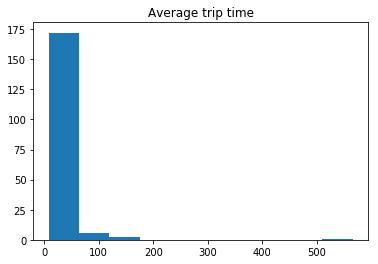

In [24]:
display_results(*press_both)

# Comparing Average Times Based on Button Pressing
Seeing the average times is useful, but we still need to compare different behaviors. Is double pressing worse than single pressing?

Single pressing will be blind. At random, the patron will choose which elevator to call

Service Elevator throughput: 90
Service Elevator mean elevator time: 45.455555555555556
Regular Elevator throughput: 85
Regular Elevator mean elevator time: 38.55294117647059
combined mean elevator time: 42.10285714285714
Worst trip time was 458


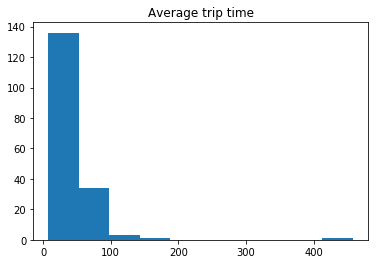

In [25]:
def press_one(temp, e1, e2):
    if np.random.randint(2):
        e1.new_customer(temp)
    else:
        e2.new_customer(temp)
        
press_one_sim = simulation(button_press_func=press_one, debug=False)
display_results(*press_one_sim)

# Comparisons
Look at the average results. If everyone presses both buttons, we get about 34 seconds of average travel time. If everyone presses one button, we get 41 seconds of average travel time.

Looking more closely at the histogram reveals an interesting result. The tail if everyone presses both buttons is longer. This means, everyone does a bit better on average, but the worst case is also worse. The worst case if everyone pressed both buttons is two minutes longer! That is a significant amount.


This is a good example of mean being a misleading statistic if the distribution is not Gaussian (not a normal curve). We have these long tails. This points to an interesting question: is everyone willing to accept a 2 minute worst case difference in exchange for 7 seconds faster.

# Looking for an Optimal Split
We define a function that either presses one or both buttons. Let's look for the best possible arrangement.

In [35]:
def press_one_or_two(temp, e1, e2, prob):
    if np.random.random() < prob:
        press_one(temp, e1, e2)
    else:
        press_both(temp, e1, e2)

In [66]:
np.linspace(0, 1, num=11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [76]:
probabilities = np.linspace(0, 1, num=11)
results = {}
for p in probabilities:
    def press_one_or_two(temp, e1, e2):
        print(temp)
        print(e1)
        print(e2)

        if np.random.random() < p:
            press_one(temp, e1, e2)
        else:
            press_both(temp, e1, e2)
    results[p] = simulation(button_press_func=press_both, time_steps=3600*24) #run for a full day


results when 0.0 % of people decide to press one button
results when 0.1 % of people decide to press one button
results when 0.2 % of people decide to press one button
results when 0.30000000000000004 % of people decide to press one button
results when 0.4 % of people decide to press one button
results when 0.5 % of people decide to press one button
results when 0.6000000000000001 % of people decide to press one button
results when 0.7000000000000001 % of people decide to press one button
results when 0.8 % of people decide to press one button
results when 0.9 % of people decide to press one button
results when 1.0 % of people decide to press one button


Text(0, 0.5, 'Time')

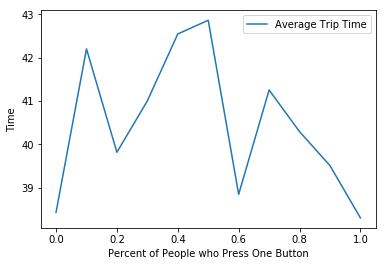

In [88]:
mean_dict, worst_dict = {}, {}
for p, result in results.items():
    print(f'results when {p} % of people decide to press one button')
    e1, e2 = result
    mean_dict[p] = np.mean(e1.average_times+e2.average_times)
    worst_dict[p] = np.max(e1.average_times+e2.average_times)
        
plt.plot(mean_dict.keys(), mean_dict.values(), label='Average Trip Time')
plt.legend()
plt.xlabel('Percent of People who Press One Button')
plt.ylabel('Time')

Text(0, 0.5, 'Time')

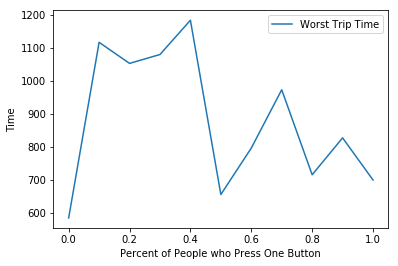

In [89]:
plt.plot(worst_dict.keys(), worst_dict.values(), label='Worst Trip Time')
plt.legend()
plt.xlabel('Percent of People who Press One Button')
plt.ylabel('Time')